In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle


from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf



# Initialize the setting

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.coarse = 20 # the number of classes
        self.feat_d = 210 # n(n-1)/2
        self.filters = 16
        self.data_dir = '..\\data\\JESTER\\'
C = Config()

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l,joint_n,joint_d):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,joint_n*joint_d))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),joint_n*joint_d))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l,joint_n,joint_d)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("JCD", M)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # 测试删去x_d_fast
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast]) # x = concatenate([x,x_d_slow,x_d_fast])
    print('concat', x.shape)
    x = block(x,filters*2)
    print('conv1', x.shape)
    x = MaxPool1D(2)(x)
    print('pool1', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    print('conv2', x.shape)
    x = MaxPool1D(2)(x)
    print('pool2', x.shape)    
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    print('conv3', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [6]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    print('pool', x.shape)    

    x = d1D(x,128)
    print('dense1', x.shape)    

    x = Dropout(0.5)(x)
    x = d1D(x,128)
    print('dense2', x.shape)    

    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    print('dense3', x.shape)    

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [9]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.coarse,C.filters)

slow Tensor("reshape/Identity:0", shape=(None, 32, 42), dtype=float32)
fast Tensor("reshape_1/Identity:0", shape=(None, 16, 42), dtype=float32)
JCD Tensor("input_1:0", shape=(None, 32, 210), dtype=float32)
concat (None, 16, 48)
conv1 (None, 16, 32)
pool1 (None, 8, 32)
conv2 (None, 8, 64)
pool2 (None, 4, 64)
conv3 (None, 4, 128)
pool (None, 128)
dense1 (None, 128)
dense2 (None, 128)
dense3 (None, 20)


In [10]:
DD_Net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 210)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 21, 2)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4, 128)       117184      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           model[1][0]                

## load data

In [11]:
# 切换成无空帧数据
Train = pickle.load(open(C.data_dir+"train_gt20_1to6.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"valid_gt20_1to6.pkl", "rb"))

## Without frame_sampling train

In [12]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Train['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|█████████████████████████████████████████████████████████████████████████████| 2456/2456 [00:18<00:00, 133.76it/s]


In [13]:
print(X_0.shape, X_1.shape, Y.shape)

label = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y:
    for e in range(len(i)):
        if i[e] == 1:
            label[e+1] += 1
            break

print(label)

(2456, 32, 210) (2456, 32, 21, 2) (2456, 20)
{1: 153, 2: 130, 3: 156, 4: 131, 5: 161, 6: 153, 7: 72, 8: 72, 9: 69, 10: 133, 11: 141, 12: 121, 13: 24, 14: 30, 15: 160, 16: 145, 17: 156, 18: 143, 19: 149, 20: 157}


In [14]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 133.46it/s]


In [17]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

label_test = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y_test:
    for e in range(len(i)):
        if i[e] == 1:
            label_test[e+1] += 1
            break

print(label_test)

(265, 32, 210) (265, 32, 21, 2) (265, 20)
{1: 13, 2: 7, 3: 16, 4: 16, 5: 13, 6: 13, 7: 5, 8: 7, 9: 7, 10: 19, 11: 19, 12: 19, 13: 4, 14: 5, 15: 15, 16: 17, 17: 15, 18: 20, 19: 18, 20: 17}


In [18]:
train_X_0 = np.vstack((X_0,X_test_0))
train_X_1 = np.vstack((X_1,X_test_1))
train_Y = np.vstack((Y,Y_test))

print(train_X_0.shape, train_X_1.shape, train_Y.shape)

import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test),
#                      validation_split=0.1
                    )

(2721, 32, 210) (2721, 32, 21, 2) (2721, 20)
Train on 2456 samples, validate on 265 samples
Epoch 1/400
2456/2456 [==============================] - 44s 18ms/sample - loss: 3.3645 - accuracy: 0.0586 - val_loss: 3.1225 - val_accuracy: 0.0528
Epoch 2/400
2456/2456 [==============================] - 1s 379us/sample - loss: 3.2164 - accuracy: 0.0782 - val_loss: 3.1589 - val_accuracy: 0.0604
Epoch 3/400
2456/2456 [==============================] - 1s 293us/sample - loss: 3.1439 - accuracy: 0.0973 - val_loss: 3.2652 - val_accuracy: 0.0604
Epoch 4/400
2456/2456 [==============================] - 1s 306us/sample - loss: 3.0162 - accuracy: 0.1201 - val_loss: 3.4845 - val_accuracy: 0.0604
Epoch 5/400
2456/2456 [==============================] - 1s 288us/sample - loss: 2.9132 - accuracy: 0.1527 - val_loss: 3.8569 - val_accuracy: 0.0604
Epoch 6/400
2456/2456 [==============================] - 1s 299us/sample - loss: 2.8774 - accuracy: 0.1490 - val_loss: 4.2714 - val_accuracy: 0.0604
Epoch 7/400
24

Epoch 110/400
2456/2456 [==============================] - 1s 287us/sample - loss: 1.1300 - accuracy: 0.6482 - val_loss: 1.4263 - val_accuracy: 0.5736
Epoch 111/400
2456/2456 [==============================] - 1s 295us/sample - loss: 1.0802 - accuracy: 0.6625 - val_loss: 1.4066 - val_accuracy: 0.5887
Epoch 112/400
2456/2456 [==============================] - 1s 307us/sample - loss: 1.0799 - accuracy: 0.6596 - val_loss: 1.3664 - val_accuracy: 0.6000
Epoch 113/400
2456/2456 [==============================] - 1s 294us/sample - loss: 1.0740 - accuracy: 0.6718 - val_loss: 1.3281 - val_accuracy: 0.6113
Epoch 114/400
2456/2456 [==============================] - 1s 293us/sample - loss: 1.0824 - accuracy: 0.6682 - val_loss: 1.2820 - val_accuracy: 0.6302
Epoch 115/400
2456/2456 [==============================] - 1s 286us/sample - loss: 1.0648 - accuracy: 0.6755 - val_loss: 1.2644 - val_accuracy: 0.6264
Epoch 116/400
2456/2456 [==============================] - 1s 292us/sample - loss: 1.0904 - ac

2456/2456 [==============================] - 1s 293us/sample - loss: 0.8438 - accuracy: 0.7451 - val_loss: 1.1395 - val_accuracy: 0.6604
Epoch 219/400
2456/2456 [==============================] - 1s 290us/sample - loss: 0.8390 - accuracy: 0.7357 - val_loss: 1.1386 - val_accuracy: 0.6604
Epoch 220/400
2456/2456 [==============================] - 1s 291us/sample - loss: 0.8578 - accuracy: 0.7378 - val_loss: 1.1377 - val_accuracy: 0.6604
Epoch 221/400
2456/2456 [==============================] - 1s 290us/sample - loss: 0.8407 - accuracy: 0.7382 - val_loss: 1.1368 - val_accuracy: 0.6604
Epoch 222/400
2456/2456 [==============================] - 1s 291us/sample - loss: 0.8659 - accuracy: 0.7309 - val_loss: 1.1360 - val_accuracy: 0.6604
Epoch 223/400
2456/2456 [==============================] - 1s 285us/sample - loss: 0.8440 - accuracy: 0.7459 - val_loss: 1.1352 - val_accuracy: 0.6604
Epoch 224/400
2456/2456 [==============================] - 1s 296us/sample - loss: 0.8606 - accuracy: 0.7280

2456/2456 [==============================] - 1s 292us/sample - loss: 0.8432 - accuracy: 0.7447 - val_loss: 1.1152 - val_accuracy: 0.6755
Epoch 327/400
2456/2456 [==============================] - 1s 297us/sample - loss: 0.8234 - accuracy: 0.7406 - val_loss: 1.1153 - val_accuracy: 0.6755
Epoch 328/400
2456/2456 [==============================] - 1s 292us/sample - loss: 0.8425 - accuracy: 0.7504 - val_loss: 1.1153 - val_accuracy: 0.6755
Epoch 329/400
2456/2456 [==============================] - 1s 287us/sample - loss: 0.8237 - accuracy: 0.7406 - val_loss: 1.1154 - val_accuracy: 0.6755
Epoch 330/400
2456/2456 [==============================] - 1s 289us/sample - loss: 0.8254 - accuracy: 0.7451 - val_loss: 1.1155 - val_accuracy: 0.6755
Epoch 331/400
2456/2456 [==============================] - 1s 291us/sample - loss: 0.8507 - accuracy: 0.7435 - val_loss: 1.1156 - val_accuracy: 0.6755
Epoch 332/400
2456/2456 [==============================] - 1s 283us/sample - loss: 0.8310 - accuracy: 0.7500

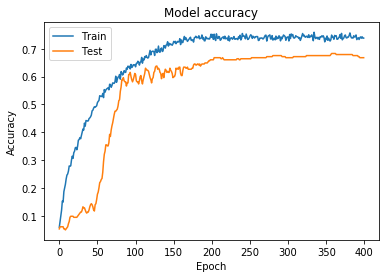

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
DD_Net.save_weights('weights/30.h5')

In [18]:
DD_Net.load_weights('weights/100.h5')

## With frame_sampling

In [30]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,21,2])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



epoch0


100%|█████████████████████████████████████████████████████████████████████████████| 7122/7122 [00:50<00:00, 140.92it/s]


Train on 7122 samples, validate on 1604 samples


# Calculate time (excute it twice, the first time initialize takes extra times)

In [22]:
import time
start_time = time.time()
y = DD_Net.predict([X_test_0,X_test_1])
time.time() - start_time

2.701770782470703

In [23]:
# 看一下正确情况
result = []
result_dict = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in y:
#     print(i)
    max = 0
    for e in range(len(i)):
        if i[e] > i[max]:
            max = e
    result_dict[max+1] += 1
    result.append(max+1)


label = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
label_list = []
for i in Y_test:
    for e in range(len(i)):
        if i[e] == 1:
            label[e+1] += 1
            label_list.append(e+1)
            break
            
print('predcit: ',result)
print('real:    ', label_list)

print('-------------分隔符----------')
print('predict: ',result_dict)
print('real:    ',label)


clscount = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y:
    for e in range(len(i)):
        if i[e] == 1:
            clscount[e+1] += 1
            break
print('-------------分隔符----------')
print(clscount)

predcit:  [11, 11, 17, 18, 5, 19, 9, 2, 3, 5, 11, 5, 2, 11, 15, 15, 11, 1, 3, 20, 5, 15, 20, 16, 16, 6, 10, 20, 6, 5, 11, 3, 19, 9, 12, 11, 17, 17, 17, 6, 5, 16, 20, 4, 10, 10, 3, 4, 5, 18, 11, 7, 8, 12, 19, 3, 18, 10, 9, 4, 20, 19, 11, 7, 17, 12, 3, 18, 5, 19, 12, 1, 16, 12, 7, 19, 11, 11, 5, 12, 12, 19, 8, 12, 11, 5, 1, 15, 16, 10, 19, 14, 11, 7, 11, 2, 15, 10, 20, 19, 11, 6, 10, 6, 15, 2, 15, 17, 11, 10, 20, 6, 6, 19, 16, 12, 4, 8, 15, 4, 10, 14, 3, 20, 20, 2, 15, 17, 5, 12, 10, 20, 9, 6, 18, 18, 1, 4, 10, 11, 19, 19, 10, 7, 19, 8, 5, 9, 20, 18, 4, 12, 17, 1, 10, 1, 20, 3, 19, 20, 15, 17, 6, 19, 11, 18, 20, 19, 1, 1, 20, 16, 19, 4, 16, 5, 8, 15, 2, 19, 4, 2, 19, 6, 18, 3, 18, 11, 14, 6, 1, 3, 4, 3, 8, 20, 8, 1, 15, 12, 1, 16, 2, 11, 4, 18, 16, 14, 16, 18, 19, 1, 4, 17, 8, 15, 16, 18, 5, 18, 3, 20, 4, 18, 16, 4, 2, 6, 12, 16, 11, 15, 12, 9, 19, 15, 12, 6, 11, 4, 16, 20, 17, 15, 7, 15, 10, 6, 20, 4, 6, 4, 20, 10, 1, 17, 17, 6, 2, 15, 14, 6, 18, 5, 2]
real:     [11, 17, 17, 18, 5, 14, 

In [26]:
# 用自己的数据实验

import matplotlib.pyplot as plt

self_skel_list = pickle.load(open("C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\myskel.pkl", "rb"))
print(self_skel_list)

for key in list(self_skel_list.keys()):
    skel = self_skel_list[key]
    
    p = np.copy(skel)
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    M = get_CG(p,C)

    X_My_0 = []
    X_My_0.append(p)
    X_My_0 = np.stack(X_My_0)

    X_My_1 = []
    X_My_1.append(M)
    X_My_1 = np.stack(X_My_1)

    y = DD_Net.predict([X_My_1,X_My_0])
    print(y)
    max = 0
    for i in range(len(y[0])):
        if y[0][i] > y[0][max]:
            max = i
            
    plt.figure(figsize=(6, 2))
    x=range(1,len(y[0])+1)

    plt.bar(x,y[0],color='blue')
    plt.xticks(x, x)
    plt.title(key)
    plt.show()
    print(key,': ',max+1)

# X_0 = []
# X_1 = []
# Y = []
# for i in tqdm(range(len(Train['pose']))): 
#     p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
#     p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
#     p = normlize_range_2d(p)
    
#     label = np.zeros(C.coarse)
#     label[Train['label'][i]-1] = 1   

#     M = get_CG(p,C)

#     X_0.append(M)
#     X_1.append(p)
#     Y.append(label)

# X_0 = np.stack(X_0)  
# X_1 = np.stack(X_1) 
# Y = np.stack(Y)

[]


AttributeError: 'list' object has no attribute 'keys'

##### Plot confusion matrix

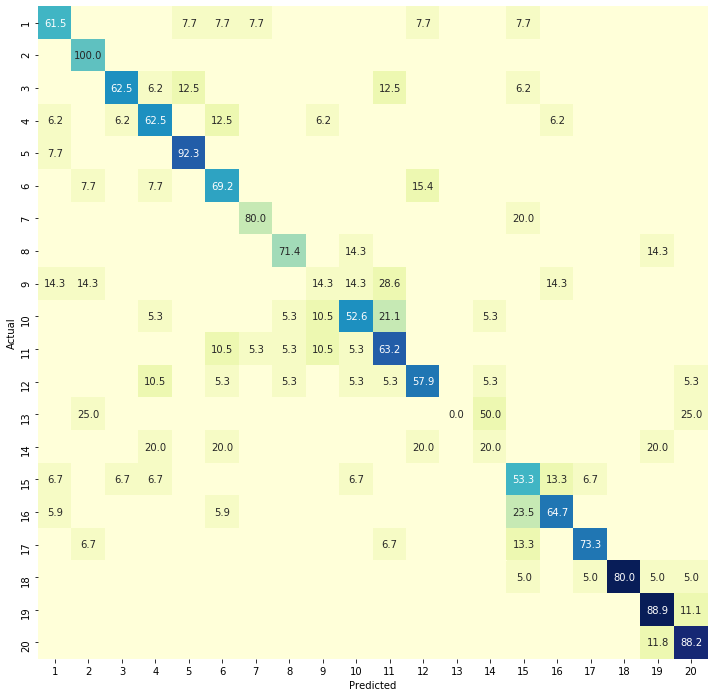

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = range(1,C.coarse+1)

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

cm_analysis(y_true,y_pred, '30.png', labels, ymap=None, figsize=(12,12))